<a href="https://colab.research.google.com/github/arakoma/pytorch_practice/blob/master/training_a_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

1.dataset ダウンロード

In [67]:
# dataset

# 変換方法はComposeに入れる
# 画素値[0,1]を[-1,1]にする
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


datasetみてみる

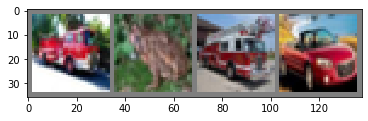

truck
frog
truck
car


In [58]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5#[-1,1]から[0,1]に戻す
    npimg = np.array(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
for x in labels:
    print(classes[x])

2.CNN定義

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

gpu使えるか確認  
NNをgpuで設定

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [74]:
net.to("cuda:0")

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

3.loss function , 最適化方法 を定義

In [0]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

4.train the network

In [76]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 1):
        # data 受取,入力もcudaに送る
        inputs, labels = data[0].to("cuda:0"), data[1].to("cuda:0")
        """
        # gpu使わない場合は
        inputs, labels = data
        """

        # gradients を初期化
        optimizer.zero_grad()

        # 学習(forward, backward, optimize)
        outputs = net.forward(inputs)#NN通す
        loss = criterion(outputs, labels)#loss計算
        loss.backward()#逆伝播
        optimizer.step()#更新

        # 経過をprint(2000 mini batches ごとの平均をprint)
        running_loss += loss.item()#.item()で値取り出し
        if i % 2000 == 0:
            print(epoch+1, i, running_loss / 2000)
            running_loss = 0.0

print("Finished Training!!!")

1 2000 2.218655541777611
1 4000 1.8607081804573535
1 6000 1.6599725677073003
1 8000 1.5549945766925812
1 10000 1.514376852452755
1 12000 1.4705504830926657
2 2000 1.3882173229306936
2 4000 1.3948168636113405
2 6000 1.3463697251230478
2 8000 1.3277814513146877
2 10000 1.2982269149571657
2 12000 1.281002789914608
Finished Training!!!


modelを保存

In [0]:
PATH = "./cifar_net.pth"
torch.save(net.state_dict(), PATH)

5.testset でテスト

testset 見てみる

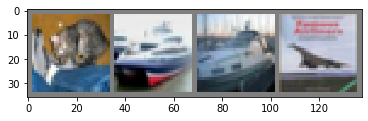

cat
ship
ship
plane


In [78]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
for x in labels:
    print(classes[x])

model をロード

In [82]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to("cuda:0")

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

上で見た4枚で予測してみる

In [83]:
outputs = net.forward(images)

_, predicted = torch.max(outputs, 1)
for x in predicted:
    print(classes[x])

cat
ship
plane
plane


dataset全体でパフォ見てみる

In [88]:
correct = 0
total = 0

with torch.no_grad():#勾配を計算保持しない
    for data in testloader:
        images, labels = data[0].to("cuda:0"), data[1].to("cuda:0")
        outputs = net.forward(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print("Accuracy of the network on the 10000 test images:", correct / total)

Accuracy of the network on the 10000 test images: 0.5565


ランダム(1/10)よりはるかにいいね！  
何か学習できてるっぽい！やった！  

classごとにパフォ見てみる

In [93]:
correct = [0.0] * 10
total = [0.0] * 10

with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to("cuda:0"), data[1].to("cuda:0")
        outputs = net.forward(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(labels.size()[0]):
            label = labels[i]
            predict = predicted[i]
            if label == predict:
                correct[predict] += 1
            total[predict] += 1

print("accuracy")
for i in range(10):
    print("%5s : %2d %%" % (classes[i], 100 * correct[i] / total[i]))

accuracy
plane : 57 %
  car : 74 %
 bird : 52 %
  cat : 37 %
 deer : 43 %
  dog : 49 %
 frog : 56 %
horse : 55 %
 ship : 75 %
truck : 60 %
